In [1]:
from stata_preprocessing import *
from llm_simulation import *
from load_environmental_distributions import load_environmental_distribution
from visualise_responses import *
from fine_tuning_prompts import *
import os
import random
from openai import OpenAI

In [2]:
age_groups = ["18-34", "35-54", "55 or older"]
base_json_filepath = "C:\\Users\\haoch\\Documents\\COMP0190\\Data\\COMP0191-MSc-Project-Code\\Synthetic-Responses-JSON\\Hypothesis-2"

In [3]:
stata_demo_question_filepath = "C:\\Users\\haoch\\Documents\\COMP0190\\Data\\COMP0191-MSc-Project-Code\\Stata-Results\\UKHLS_demo_responses.dta"

stata_demo_question_responses = load_stata_file(stata_demo_question_filepath)

stata_demo_question_responses_wave_eight, stata_demo_question_responses_wave_nine, stata_demo_question_responses_wave_ten = [stata_demo_question_responses[stata_demo_question_responses["wavename"] == wavename] for wavename in [8.0, 9.0, 10.0]]

stata_demo_question_responses_wave_ten_preprocessed = preprocess_stata_data(stata_demo_question_responses_wave_ten)

print(stata_demo_question_responses_wave_ten_preprocessed)

           sex   marstat                    qfhigh racel_dv lnprnt age_dv  \
138043    male   Married       Secondary education  British    3.0   55.0   
138044  female   Married       Secondary education  British    3.0   57.0   
138045  female   Married       No formal education  British    3.0   32.0   
138046    male   Married       Secondary education  British    2.0   33.0   
138049    male  Divorced       Secondary education  British    2.0   61.0   
...        ...       ...                       ...      ...    ...    ...   
159408    male   Married       Secondary education   Indian    2.0   77.0   
159409  female   Married  Post-secondary education   Indian    6.0   46.0   
159410    male   Married       No formal education   Indian    1.0   49.0   
159411  female    Single       Secondary education   Indian    3.0   19.0   
159412  female    Single       Secondary education   Indian    2.0   17.0   

            gor_dv    urban_dv         agegr10_dv  \
138043  North East  ur

In [4]:
print(stata_demo_question_responses_wave_ten_preprocessed["scenv_crlf"].value_counts())

I do quite a few things that are environmentally-friendly      4743
I do one or two things that are environmentally-friendly       4045
I'm environmentally-friendly in most things I do               1928
I don't really do anything that is environmentally-friendly     684
I'm environmentally-friendly in everything I do                 266
missing                                                           0
inapplicable                                                      0
proxy                                                             0
refusal                                                           0
don't know                                                        0
Name: scenv_crlf, dtype: int64


In [5]:
# Define the list of acceptable response options
demo_response_options = [
    "I don't really do anything that is environmentally-friendly",
    "I do one or two things that are environmentally-friendly",
    "I do quite a few things that are environmentally-friendly",
    "I'm environmentally-friendly in most things I do",
    "I'm environmentally-friendly in everything I do"
]

# split the data by responses: "Don't do Anything Environmentally Friendly", "Do One or Two Things Environmentally Friendly", "Do Some Things Environmentally Friendly", "Do Many Things Environmentally Friendly", "Do Everything Environmentally Friendly"
dont_do_anything_responses = stata_demo_question_responses_wave_ten_preprocessed[stata_demo_question_responses_wave_ten_preprocessed['scenv_crlf'] == "I don't really do anything that is environmentally-friendly"]

do_one_or_two_things_responses = stata_demo_question_responses_wave_ten_preprocessed[stata_demo_question_responses_wave_ten_preprocessed['scenv_crlf'] == "I do one or two things that are environmentally-friendly"]

do_some_things_responses = stata_demo_question_responses_wave_ten_preprocessed[stata_demo_question_responses_wave_ten_preprocessed['scenv_crlf'] == "I do quite a few things that are environmentally-friendly"]

do_many_things_responses = stata_demo_question_responses_wave_ten_preprocessed[stata_demo_question_responses_wave_ten_preprocessed['scenv_crlf'] == "I'm environmentally-friendly in most things I do"]

do_everything_responses = stata_demo_question_responses_wave_ten_preprocessed[stata_demo_question_responses_wave_ten_preprocessed['scenv_crlf'] == "I'm environmentally-friendly in everything I do"]

In [6]:
def write_balanced_responses_to_json(input_data, variable_name):

    num_rows = input_data.shape[0]

    print(num_rows)
    
    unique_indices = random.sample(range(num_rows), 10)

    # generate 10 random responses for each response type

    for random_index in unique_indices:
        random_row = input_data.iloc[random_index]
        profile_string, opinion_string = visualise_ukhls_profile_and_response(random_row, variable_name)

        if variable_name == "scenv_crlf":

            demo_json_filepath = "C:\\Users\\haoch\\Documents\\COMP0190\\Data\\COMP0191-MSc-Project-Code\\Stata-Results\\stata_demo_question_responses_wave_ten_demo.json"

            # write the profile and opinion to a json file
            with open(demo_json_filepath, "r") as file:
                output_data = json.load(file)

            output_data["profiles"].append(profile_string)
            output_data["opinions"].append(opinion_string)
            
            with open(demo_json_filepath, "w") as file:
                json.dump(output_data, file, indent=4)

In [7]:
write_balanced_responses_to_json(dont_do_anything_responses, "scenv_crlf")
write_balanced_responses_to_json(do_one_or_two_things_responses, "scenv_crlf")
write_balanced_responses_to_json(do_some_things_responses, "scenv_crlf")
write_balanced_responses_to_json(do_many_things_responses, "scenv_crlf")
write_balanced_responses_to_json(do_everything_responses, "scenv_crlf")

684
4045
4743
1928
266


In [8]:
# convert "Stata-Results/stata_demo_question_responses_wave_ten_demo.json" to "Stata-Results/stata_demo_question_responses_wave_ten_demo.jsonl"
def convert_json_to_jsonl(json_file_path, jsonl_file_path):
    # format the responses in this structure "{"messages": [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, {"role": "user", "content": "What's the capital of France?"}, {"role": "assistant", "content": "Paris, as if everyone doesn't know that already."}]}"
    with open(json_file_path, "r") as file:
        data = json.load(file)

    # {"role": "system", "content": "You are a happy assistant that puts a positive spin on everything."}
    # {"role": "user", "content": "I fell off my bike today."}

    with open(jsonl_file_path, "w") as file:
        for i in range(len(data["profiles"])):
            # Prepare system prompt
            system_prompt = {"role": "system", "content": data["profiles"][i]}
            
            # Prepare assistant response
            assistant_response = {"role": "assistant", "content": data["opinions"][i]}

            # Create a message list and wrap it in a dictionary
            message_dict = {"messages": [system_prompt, assistant_response]}
            
            # Dump the dictionary as a JSON formatted string to the JSONL file
            json.dump(message_dict, file)
            file.write("\n")

In [9]:
demo_json_filepath = "C:\\Users\\haoch\\Documents\\COMP0190\\Data\\COMP0191-MSc-Project-Code\\Stata-Results\\stata_demo_question_responses_wave_ten_demo.json"
demo_jsonl_filepath = "C:\\Users\\haoch\\Documents\\COMP0190\\Data\\COMP0191-MSc-Project-Code\\Stata-Results\\stata_demo_question_responses_wave_ten_demo.jsonl"
convert_json_to_jsonl(demo_json_filepath, demo_jsonl_filepath)

In [10]:
# Load the dataset
with open(demo_jsonl_filepath, 'r', encoding='utf-8') as f:
    dataset = [json.loads(line) for line in f]

# Initial dataset stats
print("Num examples:", len(dataset))
print("First example:")
for message in dataset[0]["messages"]:
    print(message)

Num examples: 450
First example:
{'role': 'system', 'content': 'I am male. My marital status is Married. In terms of my qualifications, My highest qualification is Secondary education. Racially, I am Pakistani. I have 2.0 children. I live in the South East. I live in a rural area. In terms of my age, my age group is 20-29 years old. My profession is Intermediate Occupations. Ideologically, I describe myself as a Other Party supporter. Financially, my monthly income is £3669.When I asked to write my response to the question, "And which of these would you say best describes your current lifestyle?", I respond with: '}
{'role': 'assistant', 'content': "I don't really do anything that is environmentally-friendly"}


In [11]:
hypothesis_one_model_demo_question = OpenAI()

In [12]:
from api_key import get_api_key

api_key = get_api_key()

In [13]:
demo_question_model_id = "ft:gpt-3.5-turbo-0125:personal::9lfqGolS"

In [14]:
# client = OpenAI(api_key = api_key)

# response = client.files.create(
#     file=open(demo_jsonl_filepath, 'rb'),
#     purpose = 'fine-tune'
# )

# print(response)
# response_id = response.id

In [15]:
# hypothesis_one_model_demo_question.fine_tuning.jobs.create(training_file = response_id, model="gpt-3.5-turbo")

In [16]:
demo_question = "And which of these would you say best describes your current lifestyle?"
question_number = 1
demo_potential_answers = ["Don't do Anything Environmentally Friendly", "Do One or Two Things Environmentally Friendly", "Do Some Things Environmentally Friendly", "Do Many Things Environmentally Friendly", "Do Everything Environmentally Friendly"]
n_samples = 100
json_filepath = "C:\\Users\\haoch\\Documents\\COMP0190\\Data\\COMP0191-MSc-Project-Code\\Synthetic-Responses-JSON\\synthetic_demo_responses_finetuned.json"
distributions = [load_environmental_distribution("scenv_crlf", 1), load_environmental_distribution("scenv_crlf", 4), load_environmental_distribution("scenv_crlf", 10)]
wave_numbers = [1, 4, 10]
is_simulate = True

Type of most_similar_index: <class 'numpy.int64'>
Value of most_similar_index: 3
Type of most_similar_index: <class 'numpy.int64'>
Value of most_similar_index: 3
Type of most_similar_index: <class 'numpy.int64'>
Value of most_similar_index: 0
Type of most_similar_index: <class 'numpy.int64'>
Value of most_similar_index: 3
Type of most_similar_index: <class 'numpy.int64'>
Value of most_similar_index: 3
Type of most_similar_index: <class 'numpy.int64'>
Value of most_similar_index: 1
Type of most_similar_index: <class 'numpy.int64'>
Value of most_similar_index: 1
Type of most_similar_index: <class 'numpy.int64'>
Value of most_similar_index: 1
Type of most_similar_index: <class 'numpy.int64'>
Value of most_similar_index: 1
Type of most_similar_index: <class 'numpy.int64'>
Value of most_similar_index: 1
Type of most_similar_index: <class 'numpy.int64'>
Value of most_similar_index: 3
Type of most_similar_index: <class 'numpy.int64'>
Value of most_similar_index: 3
Type of most_similar_index: 

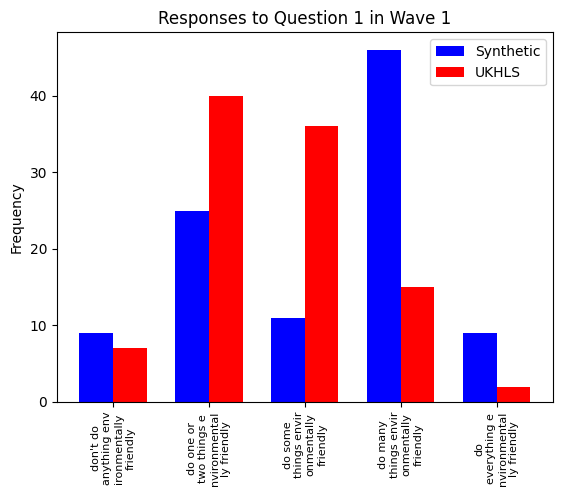

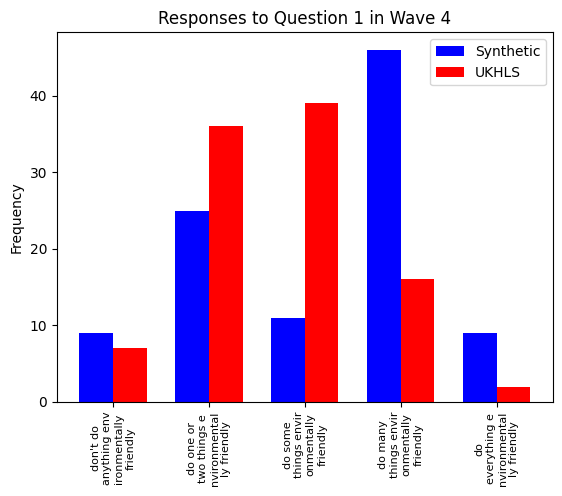

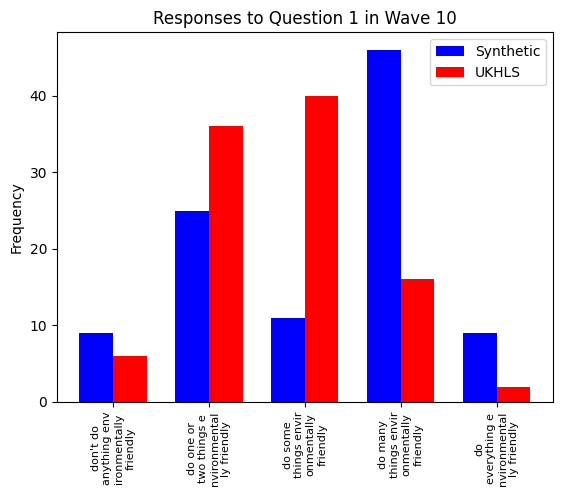

In [17]:
simulate_environmental_responses(demo_question, question_number, demo_potential_answers, n_samples, json_filepath, distributions, wave_numbers, 1, is_simulate, 0, "", True, demo_question_model_id)